# QuantNote - Tutorial Didático

## Sistema Quantitativo para Probabilidades de Retorno Condicionadas por Regime

Este notebook demonstra passo a passo o funcionamento do sistema QuantNote.

### Objetivo
Calcular a probabilidade de um ativo atingir um retorno alvo em H períodos, condicionada ao regime de mercado atual.

### Conceitos Principais
1. **Log-Retornos**: Usamos log(P_t/P_{t-1}) pois são aditivos e simétricos
2. **Slope (Inclinação)**: Tendência calculada via regressão linear do log-preço
3. **Volatilidade**: Desvio padrão dos retornos em janela móvel
4. **Regimes**: Estados do mercado (bull/bear/flat combinados com alta/baixa volatilidade)
5. **K-Means**: Clustering para detectar regimes automaticamente
6. **Walk-Forward**: Validação para evitar overfitting

## Etapa 1: Setup e Imports

Primeiro, configuramos o ambiente e importamos os módulos necessários.

In [1]:
# Setup do path para imports
import sys
import os
sys.path.insert(0, os.path.dirname(os.getcwd()))

# Imports padrão
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Verificar se os imports funcionam
print("Python path configurado!")
print(f"Diretório de trabalho: {os.getcwd()}")

# Configuração de visualização
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 200)

Python path configurado!
Diretório de trabalho: /home/flavio/projetos/quantnote/notebooks


## Etapa 2: Configuração do Sistema

O sistema usa Pydantic para validar configurações. Isso garante que parâmetros inválidos sejam rejeitados.

In [2]:
from config.settings import AnalysisConfig, InfrastructureConfig, Config

# Criar configuração
config = Config()

# Personalizar parâmetros
config.analysis.future_return_periods = 7  # Horizonte de 3 dias
config.analysis.window_slope = 20          # Janela de 20 dias para slope
config.analysis.window_volatility = 20     # Janela de 20 dias para volatilidade
config.analysis.n_clusters = 6             # 3 regimes
config.analysis.target_return = 0.05       # Target de 5%

print("=== Configuração de Análise ===")
print(f"Horizonte futuro: {config.analysis.future_return_periods} dias")
print(f"Janela slope: {config.analysis.window_slope}")
print(f"Janela volatilidade: {config.analysis.window_volatility}")
print(f"Número de clusters: {config.analysis.n_clusters}")
print(f"Retorno alvo: {config.analysis.target_return:.1%}")

=== Configuração de Análise ===
Horizonte futuro: 7 dias
Janela slope: 20
Janela volatilidade: 20
Número de clusters: 6
Retorno alvo: 5.0%


## Etapa 3: Obtenção de Dados

Usamos `YahooDataSource` para baixar dados OHLCV. O sistema tem rate limiting para evitar bloqueio.

In [3]:
from src.infrastructure.yahoo_data_source import YahooDataSource
from src.infrastructure.parquet_repository import ParquetRepository
from src.infrastructure.file_logger import FileLogger, NullLogger

# Criar logger (usar NullLogger para menos output)
logger = NullLogger()  # ou FileLogger("quantnote") para logs detalhados

# Data source e repository
data_source = YahooDataSource(calls_per_minute=5, logger=logger)
repository = ParquetRepository(data_dir="../data", logger=logger)

# Ticker a analisar
ticker = "BOVA11.SA"  # ETF do Ibovespa

print(f"Buscando dados para {ticker}...")

# Tentar carregar do cache primeiro
df = repository.load(ticker)
if df is None:
    print("Dados não encontrados no cache. Baixando do Yahoo Finance...")
    df = data_source.fetch_ohlcv(ticker)
    repository.save(df, ticker)
    print("Dados salvos no cache.")
else:
    print("Dados carregados do cache.")

print(f"\n=== Dados Obtidos ===")
print(f"Shape: {df.shape}")
print(f"Período: {df['date'].min().date()} a {df['date'].max().date()}")
print(f"\nPrimeiras linhas:")
df.head()

Buscando dados para BOVA11.SA...
Dados carregados do cache.

=== Dados Obtidos ===
Shape: (4100, 6)
Período: 2009-04-17 a 2025-11-28

Primeiras linhas:


,date,open,high,low,close,volume
0,2009-04-17,45.700001,45.980000,45.599998,45.849998,274700
1,2009-04-20,44.790001,44.900002,44.070000,44.419998,265800
2,2009-04-22,44.610001,45.240002,44.509998,44.990002,234800
3,2009-04-23,45.189999,45.900002,44.860001,45.900002,305900
4,2009-04-24,46.169998,46.849998,46.099998,46.689999,325600


## Etapa 4: Validação de Dados

Antes de processar, validamos os dados para garantir qualidade.

O sistema usa o padrão **Composite** para combinar múltiplos validadores.

In [4]:
from src.infrastructure.validators import create_default_validator

# Criar validador composto
validator = create_default_validator(
    min_length=config.analysis.min_data_points,
    max_window=max(config.analysis.window_slope, config.analysis.window_volatility)
)

# Executar validação
validation = validator.validate(df)

print("=== Resultado da Validação ===")
print(f"Válido: {'SIM' if validation.is_valid else 'NÃO'}")

if validation.errors:
    print(f"\nERROS:")
    for error in validation.errors:
        print(f"  - {error}")

if validation.warnings:
    print(f"\nAVISOS:")
    for warning in validation.warnings:
        print(f"  - {warning}")

if validation.is_valid and not validation.warnings:
    print("Todos os testes passaram sem avisos!")

=== Resultado da Validação ===
Válido: SIM

AVISOS:
  - Gaps > 5 days found: ['2012-02-23 (6.0 days)', '2018-03-06 (6.0 days)', '2019-03-06 (7.0 days)', '2019-03-21 (8.0 days)']


## Etapa 5: Calculadores Individuais

Vamos explorar cada calculador individualmente para entender o que faz.

Cada calculador implementa `IColumnCalculator` e segue o princípio de **Single Responsibility**.

In [5]:
from src.calculators.log_price_calculator import LogPriceCalculator

# 5.1 - Log Price Calculator
log_price_calc = LogPriceCalculator()

print("=== LogPriceCalculator ===")
print(f"Nome: {log_price_calc.name}")
print(f"Colunas requeridas: {log_price_calc.required_columns}")
print(f"Colunas produzidas: {log_price_calc.output_columns}")

# Aplicar
df_step1 = log_price_calc.calculate(df)

# Visualizar resultado
print(f"\nFormula: log_close = ln(close)")
print(f"\nExemplo:")
print(df_step1[['date', 'close', 'log_close']].head())

=== LogPriceCalculator ===
Nome: log_price
Colunas requeridas: {'close'}
Colunas produzidas: {'log_close'}

Formula: log_close = ln(close)

Exemplo:
        date      close  log_close
0 2009-04-17  45.849998   3.825375
1 2009-04-20  44.419998   3.793690
2 2009-04-22  44.990002   3.806440
3 2009-04-23  45.900002   3.826465
4 2009-04-24  46.689999   3.843530


In [6]:
from src.calculators.log_return_calculator import LogReturnCalculator

# 5.2 - Log Return Calculator
log_return_calc = LogReturnCalculator(window=config.analysis.window_rolling_return)

print("=== LogReturnCalculator ===")
print(f"Nome: {log_return_calc.name}")
print(f"Colunas requeridas: {log_return_calc.required_columns}")
print(f"Colunas produzidas: {log_return_calc.output_columns}")

# Aplicar
df_step2 = log_return_calc.calculate(df_step1)

print(f"\nFormulas:")
print(f"  log_return = ln(close_t / close_{{t-1}})")
print(f"  log_return_rolling_20 = sum(log_return over 20 days)")
print(f"\nExemplo:")
print(df_step2[['date', 'close', 'log_return', f'log_return_rolling_{config.analysis.window_rolling_return}']].head(25))

=== LogReturnCalculator ===
Nome: log_return_w20
Colunas requeridas: {'close'}
Colunas produzidas: {'log_return_rolling_20', 'log_return'}

Formulas:
  log_return = ln(close_t / close_{t-1})
  log_return_rolling_20 = sum(log_return over 20 days)

Exemplo:
         date      close  log_return  log_return_rolling_20
0  2009-04-17  45.849998         NaN                    NaN
1  2009-04-20  44.419998   -0.031685                    NaN
2  2009-04-22  44.990002    0.012751                    NaN
3  2009-04-23  45.900002    0.020025                    NaN
4  2009-04-24  46.689999    0.017065                    NaN
5  2009-04-27  45.900002   -0.017065                    NaN
6  2009-04-28  45.849998   -0.001090                    NaN
7  2009-04-29  46.799999    0.020508                    NaN
8  2009-04-30  48.099998    0.027399                    NaN
9  2009-05-04  50.000000    0.038741                    NaN
10 2009-05-05  50.650002    0.012916                    NaN
11 2009-05-06  51.360001

In [7]:
from src.calculators.volatility_calculator import VolatilityCalculator

# 5.3 - Volatility Calculator
vol_calc = VolatilityCalculator(window=config.analysis.window_volatility)

print("=== VolatilityCalculator ===")
print(f"Nome: {vol_calc.name}")
print(f"Colunas requeridas: {vol_calc.required_columns}")
print(f"Colunas produzidas: {vol_calc.output_columns}")

# Aplicar
df_step3 = vol_calc.calculate(df_step2)

print(f"\nFormula: volatility = std(log_return over {config.analysis.window_volatility} days)")
print(f"\nExemplo:")
print(df_step3[['date', 'log_return', f'volatility_{config.analysis.window_volatility}']].tail(10))

=== VolatilityCalculator ===
Nome: volatility_w20
Colunas requeridas: {'log_return'}
Colunas produzidas: {'volatility_20'}

Formula: volatility = std(log_return over 20 days)

Exemplo:
           date  log_return  volatility_20
4090 2025-11-14    0.001556       0.005611
4091 2025-11-17   -0.003570       0.005895
4092 2025-11-18   -0.001692       0.005942
4093 2025-11-19   -0.010015       0.006732
4094 2025-11-21   -0.000329       0.006762
4095 2025-11-24    0.002629       0.006760
4096 2025-11-25    0.004061       0.006704
4097 2025-11-26    0.017946       0.007483
4098 2025-11-27   -0.002700       0.007584
4099 2025-11-28    0.003406       0.007583


In [8]:
from src.calculators.slope_calculator import SlopeCalculator

# 5.4 - Slope Calculator
slope_calc = SlopeCalculator(window=config.analysis.window_slope)

print("=== SlopeCalculator ===")
print(f"Nome: {slope_calc.name}")
print(f"Colunas requeridas: {slope_calc.required_columns}")
print(f"Colunas produzidas: {slope_calc.output_columns}")

# Aplicar
df_step4 = slope_calc.calculate(df_step3)

print(f"\nFormula: slope = coef angular da regressão linear de log_close sobre {config.analysis.window_slope} dias")
print(f"\nInterpretação:")
print(f"  slope > 0: tendência de alta")
print(f"  slope < 0: tendência de baixa")
print(f"  slope ≈ 0: mercado lateral")
print(f"\nExemplo:")
print(df_step4[['date', 'log_close', f'slope_{config.analysis.window_slope}']].tail(10))

=== SlopeCalculator ===
Nome: slope_w20
Colunas requeridas: {'log_close'}
Colunas produzidas: {'slope_20'}

Formula: slope = coef angular da regressão linear de log_close sobre 20 dias

Interpretação:
  slope > 0: tendência de alta
  slope < 0: tendência de baixa
  slope ≈ 0: mercado lateral

Exemplo:
           date  log_close  slope_20
4090 2025-11-14   5.039158  0.005337
4091 2025-11-17   5.035588  0.005248
4092 2025-11-18   5.033896  0.004996
4093 2025-11-19   5.023881  0.004554
4094 2025-11-21   5.023551  0.004093
4095 2025-11-24   5.026181  0.003609
4096 2025-11-25   5.030242  0.003199
4097 2025-11-26   5.048188  0.002989
4098 2025-11-27   5.045488  0.002733
4099 2025-11-28   5.048894  0.002468


In [9]:
from src.calculators.future_return_calculator import FutureReturnCalculator

# 5.5 - Future Return Calculator
future_calc = FutureReturnCalculator(horizon=config.analysis.future_return_periods)

print("=== FutureReturnCalculator ===")
print(f"Nome: {future_calc.name}")
print(f"Colunas requeridas: {future_calc.required_columns}")
print(f"Colunas produzidas: {future_calc.output_columns}")

# Aplicar
df_step5 = future_calc.calculate(df_step4)

print(f"\nFormula: log_return_future_{config.analysis.future_return_periods} = ln(close_{{t+{config.analysis.future_return_periods}}} / close_t)")
print(f"\nNOTA: Esta coluna é a variável TARGET que queremos prever!")
print(f"\nExemplo:")
print(df_step5[['date', 'close', f'log_return_future_{config.analysis.future_return_periods}']].head(10))

=== FutureReturnCalculator ===
Nome: future_return_h7
Colunas requeridas: {'close'}
Colunas produzidas: {'log_return_future_7'}

Formula: log_return_future_7 = ln(close_{t+7} / close_t)

NOTA: Esta coluna é a variável TARGET que queremos prever!

Exemplo:
        date      close  log_return_future_7
0 2009-04-17  45.849998             0.020508
1 2009-04-20  44.419998             0.079592
2 2009-04-22  44.990002             0.105583
3 2009-04-23  45.900002             0.098474
4 2009-04-24  46.689999             0.095330
5 2009-04-27  45.900002             0.086557
6 2009-04-28  45.849998             0.113485
7 2009-04-29  46.799999             0.085942
8 2009-04-30  48.099998             0.044723
9 2009-05-04  50.000000            -0.038741


## Etapa 6: Pipeline com Resolução Automática de Dependências

O `CalculatorPipeline` usa **topological sort** para ordenar os calculadores automaticamente.

Isso implementa o princípio **Open/Closed** - podemos adicionar calculadores sem modificar o pipeline.

In [10]:
from src.calculators.pipeline import CalculatorPipeline
from src.calculators.log_price_calculator import LogPriceCalculator
from src.calculators.log_return_calculator import LogReturnCalculator
from src.calculators.future_return_calculator import FutureReturnCalculator
from src.calculators.volatility_calculator import VolatilityCalculator
from src.calculators.slope_calculator import SlopeCalculator

# Criar pipeline (note que a ordem não importa - será resolvida automaticamente)
pipeline = CalculatorPipeline([
    SlopeCalculator(window=config.analysis.window_slope),      # Depende de log_close
    LogReturnCalculator(window=config.analysis.window_rolling_return),  # Depende de close
    VolatilityCalculator(window=config.analysis.window_volatility),     # Depende de log_return
    LogPriceCalculator(),                                       # Depende de close
    FutureReturnCalculator(horizon=config.analysis.future_return_periods)  # Depende de close
], logger=logger)

# Executar pipeline
df_analysis = pipeline.run(df)

print("=== Pipeline Executado ===")
print(f"Ordem de execução: {pipeline.get_execution_order()}")
print(f"\nColunas originais: {len(df.columns)}")
print(f"Colunas após pipeline: {len(df_analysis.columns)}")
print(f"\nNovas colunas: {list(pipeline.get_all_output_columns())}")

=== Pipeline Executado ===
Ordem de execução: ['log_return_w20', 'log_price', 'future_return_h7', 'volatility_w20', 'slope_w20']

Colunas originais: 6
Colunas após pipeline: 12

Novas colunas: ['slope_20', 'log_close', 'log_return_future_7', 'log_return', 'log_return_rolling_20', 'volatility_20']


In [11]:
# Visualizar resultado do pipeline
print("=== Dados Após Pipeline ===")
df_analysis.head()

=== Dados Após Pipeline ===


,date,open,high,low,close,volume,log_return,log_return_rolling_20,log_close,log_return_future_7,volatility_20,slope_20
0,2009-04-17,45.700001,45.980000,45.599998,45.849998,274700,NaN,NaN,3.825375,0.020508,NaN,NaN
1,2009-04-20,44.790001,44.900002,44.070000,44.419998,265800,-0.031685,NaN,3.793690,0.079592,NaN,NaN
2,2009-04-22,44.610001,45.240002,44.509998,44.990002,234800,0.012751,NaN,3.806440,0.105583,NaN,NaN
3,2009-04-23,45.189999,45.900002,44.860001,45.900002,305900,0.020025,NaN,3.826465,0.098474,NaN,NaN
4,2009-04-24,46.169998,46.849998,46.099998,46.689999,325600,0.017065,NaN,3.843530,0.095330,NaN,NaN


## Etapa 7: Classificação Manual de Regimes

Uma abordagem é usar thresholds manuais para classificar regimes baseado em slope e volatilidade.

In [12]:
from src.analysis.regime_classifier import ManualRegimeClassifier

# Nomes das colunas
slope_col = f'slope_{config.analysis.window_slope}'
vol_col = f'volatility_{config.analysis.window_volatility}'

# Criar classificador manual (thresholds automáticos)
manual_classifier = ManualRegimeClassifier(
    slope_column=slope_col,
    volatility_column=vol_col
)

# Classificar
df_manual = manual_classifier.classify(df_analysis)

# Resultados
print("=== Classificação Manual de Regimes ===")
print(f"\nThresholds usados: {manual_classifier.get_thresholds()}")
print(f"\nDistribuição de regimes:")
print(df_manual['regime'].value_counts())

=== Classificação Manual de Regimes ===

Thresholds usados: {'slope_threshold': np.float64(0.0017647842593167388), 'volatility_threshold': np.float64(0.012375619153040501)}

Distribuição de regimes:
regime
flat_low_vol     923
flat_high_vol    825
bull_low_vol     762
bear_high_vol    609
bull_high_vol    606
bear_low_vol     355
Name: count, dtype: int64


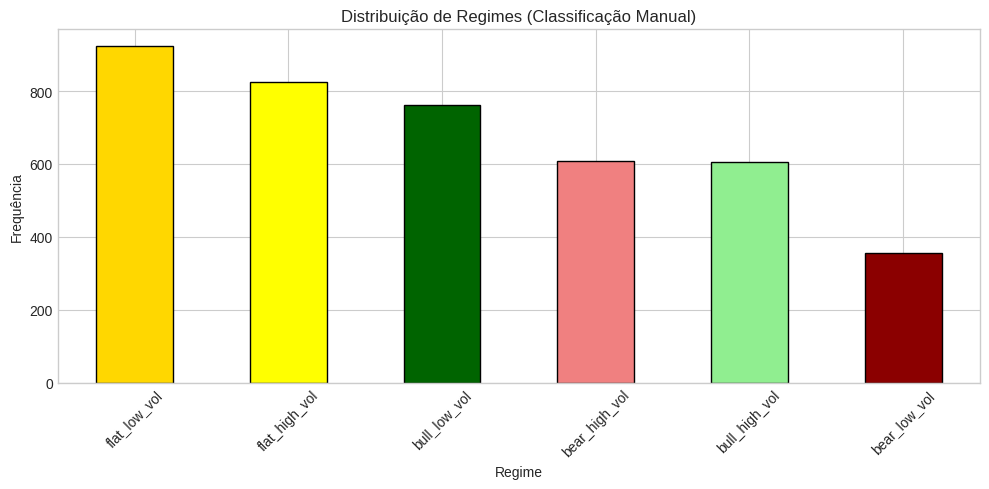

In [13]:
# Visualizar distribuição por regime
regime_counts = df_manual['regime'].value_counts()

fig, ax = plt.subplots(figsize=(10, 5))
colors = {
    'bull_high_vol': 'lightgreen',
    'bull_low_vol': 'darkgreen',
    'bear_high_vol': 'lightcoral',
    'bear_low_vol': 'darkred',
    'flat_high_vol': 'yellow',
    'flat_low_vol': 'gold'
}
bar_colors = [colors.get(r, 'gray') for r in regime_counts.index]
regime_counts.plot(kind='bar', ax=ax, color=bar_colors, edgecolor='black')
ax.set_title('Distribuição de Regimes (Classificação Manual)')
ax.set_xlabel('Regime')
ax.set_ylabel('Frequência')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Etapa 8: Classificação com K-Means

K-Means detecta regimes automaticamente baseado em múltiplas features.

Isso é mais robusto que thresholds manuais pois considera todas as features simultaneamente.

In [14]:
from src.analysis.kmeans_regimes import KMeansRegimeClassifier

# Criar classificador K-Means
kmeans = KMeansRegimeClassifier(
    n_clusters=config.analysis.n_clusters,
    logger=logger
)

# Fit e Predict
df_kmeans = kmeans.fit_predict(df_analysis)

print("=== Classificação K-Means ===")
print(f"\nFeatures usadas: {kmeans.feature_columns}")
print(f"Número de clusters: {config.analysis.n_clusters}")
print(f"\nDistribuição de clusters:")
print(df_kmeans['cluster'].value_counts().sort_index())

=== Classificação K-Means ===

Features usadas: ['log_return_rolling_20', 'volatility_20', 'slope_20']
Número de clusters: 6

Distribuição de clusters:
cluster
0.0     231
1.0    1351
2.0      21
3.0    1328
4.0     461
5.0     688
Name: count, dtype: int64


In [15]:
# Estatísticas por cluster
future_col = f'log_return_future_{config.analysis.future_return_periods}'
stats = kmeans.compute_statistics(df_kmeans, future_col)
interpretations = kmeans.interpret_clusters(df_kmeans, slope_col)

print("=== Estatísticas por Cluster ===")
for stat in stats:
    interp = interpretations.get(stat.cluster_id, 'unknown')
    print(f"\nCluster {stat.cluster_id} ({interp.upper()}):")
    print(f"  Observações: {stat.count} ({stat.percentage:.1f}%)")
    print(f"  Retorno futuro médio: {stat.future_return_mean:.4f}")
    print(f"  Desvio padrão: {stat.future_return_std:.4f}")
    print(f"  Features médias: {stat.feature_means}")

=== Estatísticas por Cluster ===

Cluster 0 (BULL):
  Observações: 231 (5.7%)
  Retorno futuro médio: 0.0062
  Desvio padrão: 0.0409
  Features médias: {'log_return_rolling_20': np.float64(0.10488601508113492), 'volatility_20': np.float64(0.020695813166758913), 'slope_20': np.float64(0.005610599189370642)}

Cluster 1 (BEAR):
  Observações: 1351 (33.1%)
  Retorno futuro médio: 0.0003
  Desvio padrão: 0.0320
  Features médias: {'log_return_rolling_20': np.float64(-0.02041476198095612), 'volatility_20': np.float64(0.010908916900523577), 'slope_20': np.float64(-0.001267398219083043)}

Cluster 2 (BEAR):
  Observações: 21 (0.5%)
  Retorno futuro médio: 0.0201
  Desvio padrão: 0.0975
  Features médias: {'log_return_rolling_20': np.float64(-0.3791497970483564), 'volatility_20': np.float64(0.07262530136249647), 'slope_20': np.float64(-0.019807164619668534)}

Cluster 3 (BULL):
  Observações: 1328 (32.5%)
  Retorno futuro médio: 0.0009
  Desvio padrão: 0.0300
  Features médias: {'log_return_rolli

## Etapa 9: Cálculo de Probabilidades

Agora calculamos a probabilidade de atingir o retorno alvo, condicionada por regime.

In [16]:
from src.analysis.probability_calculator import ProbabilityCalculator

# Usando classificação manual
prob_calc_manual = ProbabilityCalculator(
    future_return_column=future_col,
    target_return=config.analysis.target_return,
    regime_column='regime'
)

# Gerar relatório completo
report = prob_calc_manual.generate_report(df_manual)

print("=== Relatório de Probabilidades (Regimes Manuais) ===")
print(f"\nRetorno alvo: {report['target_return']:.1%}")
print(f"Log-retorno alvo: {report['log_target']:.4f}")
print(f"\nProbabilidade incondicional: {report['raw_probability_pct']:.2f}%")

print(f"\nProbabilidades condicionais:")
for regime, data in report['conditional_probabilities'].items():
    print(f"  {regime}:")
    print(f"    P(hit) = {data['probability_pct']:.2f}%")
    print(f"    n = {data['count']}")
    print(f"    retorno médio = {data['mean_return']:.4f}")

print(f"\nMétricas de separação:")
print(f"  Delta P: {report['separation_metrics']['delta_p']:.4f}")
print(f"  (diferença entre maior e menor probabilidade)")
print(f"  Information Ratio: {report['separation_metrics']['information_ratio']:.4f}")

=== Relatório de Probabilidades (Regimes Manuais) ===

Retorno alvo: 5.0%
Log-retorno alvo: 0.0488

Probabilidade incondicional: 7.99%

Probabilidades condicionais:
  bull_high_vol:
    P(hit) = 8.58%
    n = 606
    retorno médio = 0.0054
  flat_high_vol:
    P(hit) = 10.91%
    n = 825
    retorno médio = 0.0055
  bear_high_vol:
    P(hit) = 12.48%
    n = 609
    retorno médio = -0.0004
  bull_low_vol:
    P(hit) = 2.78%
    n = 755
    retorno médio = 0.0020
  flat_low_vol:
    P(hit) = 5.42%
    n = 923
    retorno médio = -0.0008
  bear_low_vol:
    P(hit) = 8.17%
    n = 355
    retorno médio = -0.0017

Métricas de separação:
  Delta P: 0.0970
  (diferença entre maior e menor probabilidade)
  Information Ratio: 0.1945


In [17]:
# Usando classificação K-Means
prob_calc_kmeans = ProbabilityCalculator(
    future_return_column=future_col,
    target_return=config.analysis.target_return,
    regime_column='cluster'
)

report_kmeans = prob_calc_kmeans.generate_report(df_kmeans)

print("=== Relatório de Probabilidades (K-Means) ===")
print(f"\nRetorno alvo: {report_kmeans['target_return']:.1%}")
print(f"\nProbabilidade incondicional: {report_kmeans['raw_probability_pct']:.2f}%")

print(f"\nProbabilidades por cluster:")
for cluster_id, data in sorted(report_kmeans['conditional_probabilities'].items()):
    interp = interpretations.get(int(float(cluster_id)), 'unknown')
    print(f"  Cluster {cluster_id} ({interp}): P(hit) = {data['probability_pct']:.2f}% (n={data['count']})")

print(f"\nDelta P: {report_kmeans['separation_metrics']['delta_p']:.4f}")

=== Relatório de Probabilidades (K-Means) ===

Retorno alvo: 5.0%

Probabilidade incondicional: 7.99%

Probabilidades por cluster:
  Cluster 0.0 (bull): P(hit) = 9.96% (n=231)
  Cluster 1.0 (bear): P(hit) = 7.03% (n=1351)
  Cluster 2.0 (bear): P(hit) = 47.62% (n=21)
  Cluster 3.0 (bull): P(hit) = 3.94% (n=1321)
  Cluster 4.0 (bear): P(hit) = 13.23% (n=461)
  Cluster 5.0 (flat): P(hit) = 11.19% (n=688)

Delta P: 0.4368


## Etapa 10: Visualizações

Visualizamos a distribuição de retornos por regime.

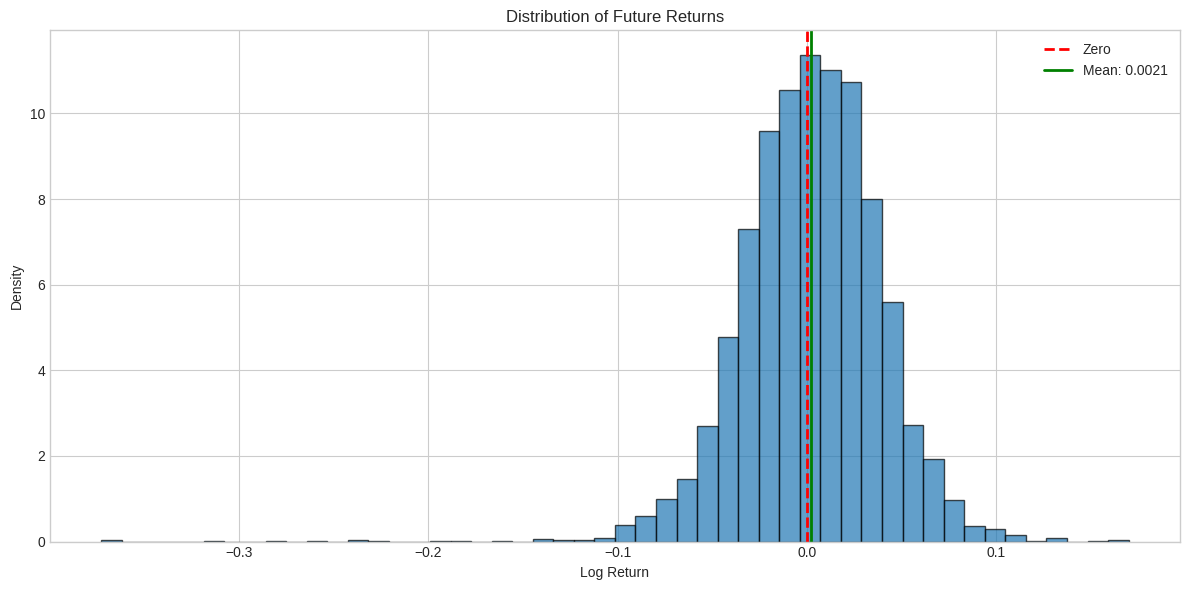

In [18]:
from src.visualization.histogram_plotter import HistogramPlotter, PriceRegimePlotter

# Histograma geral
hist_plotter = HistogramPlotter(
    return_column=future_col,
    regime_column='regime'
)

fig = hist_plotter.plot(df_manual)
plt.show()

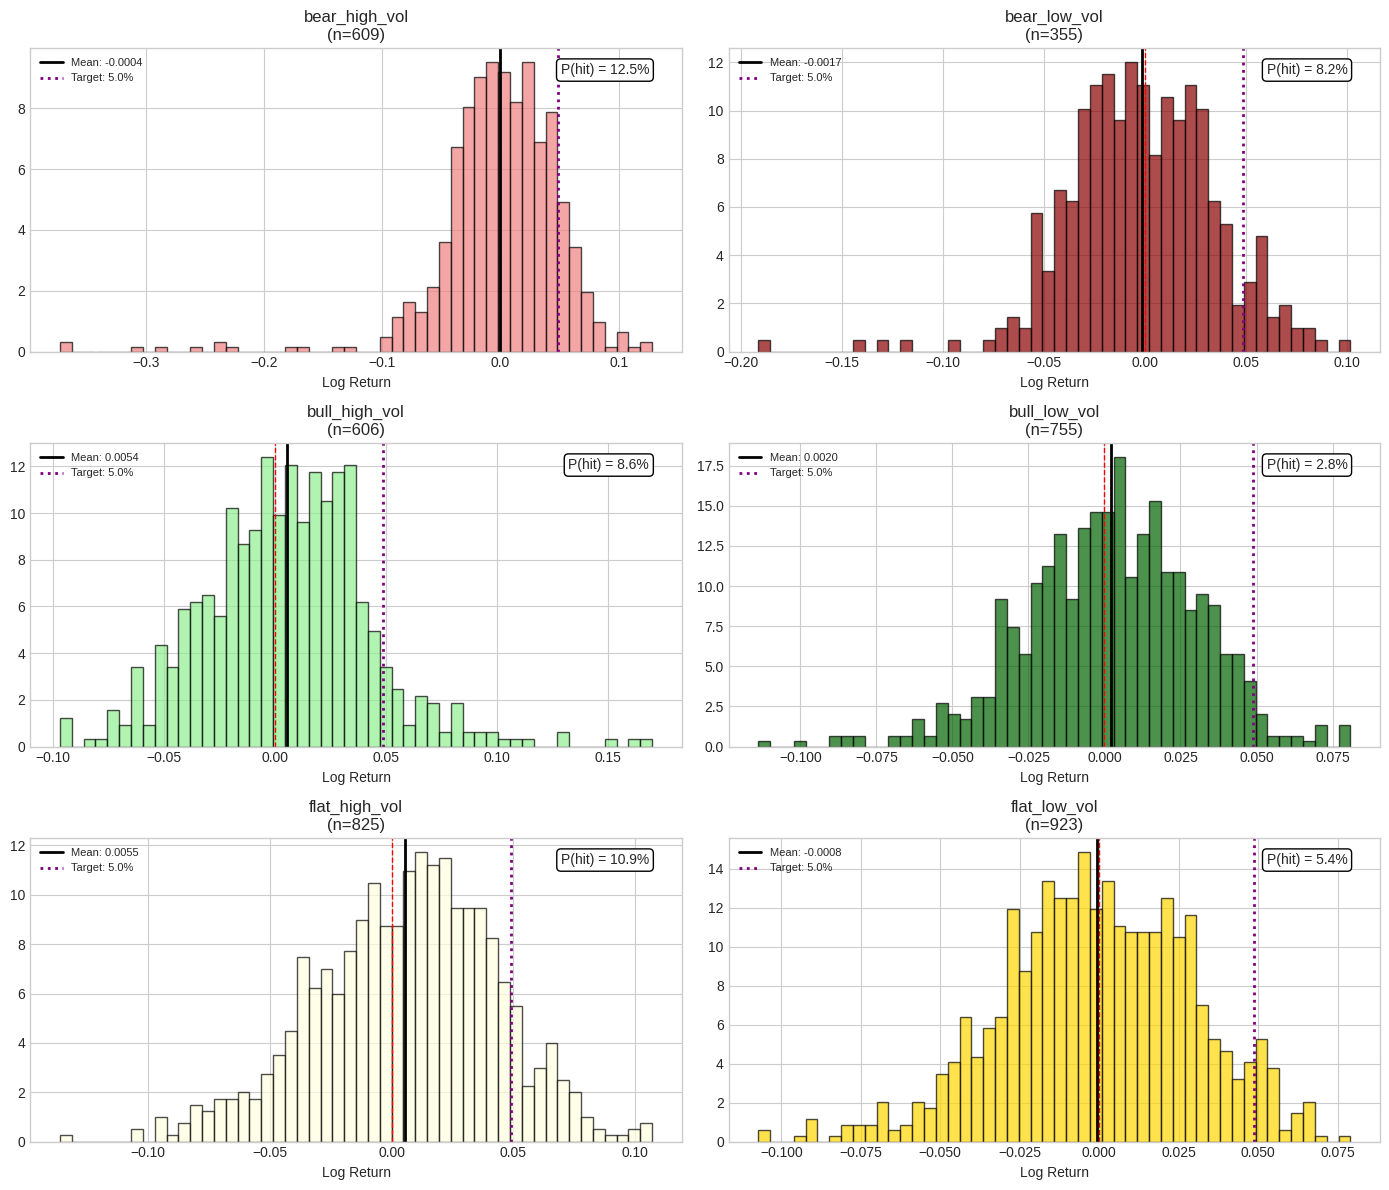

In [19]:
# Histogramas por regime
fig = hist_plotter.plot_by_regime(df_manual, target_return=config.analysis.target_return)
plt.show()

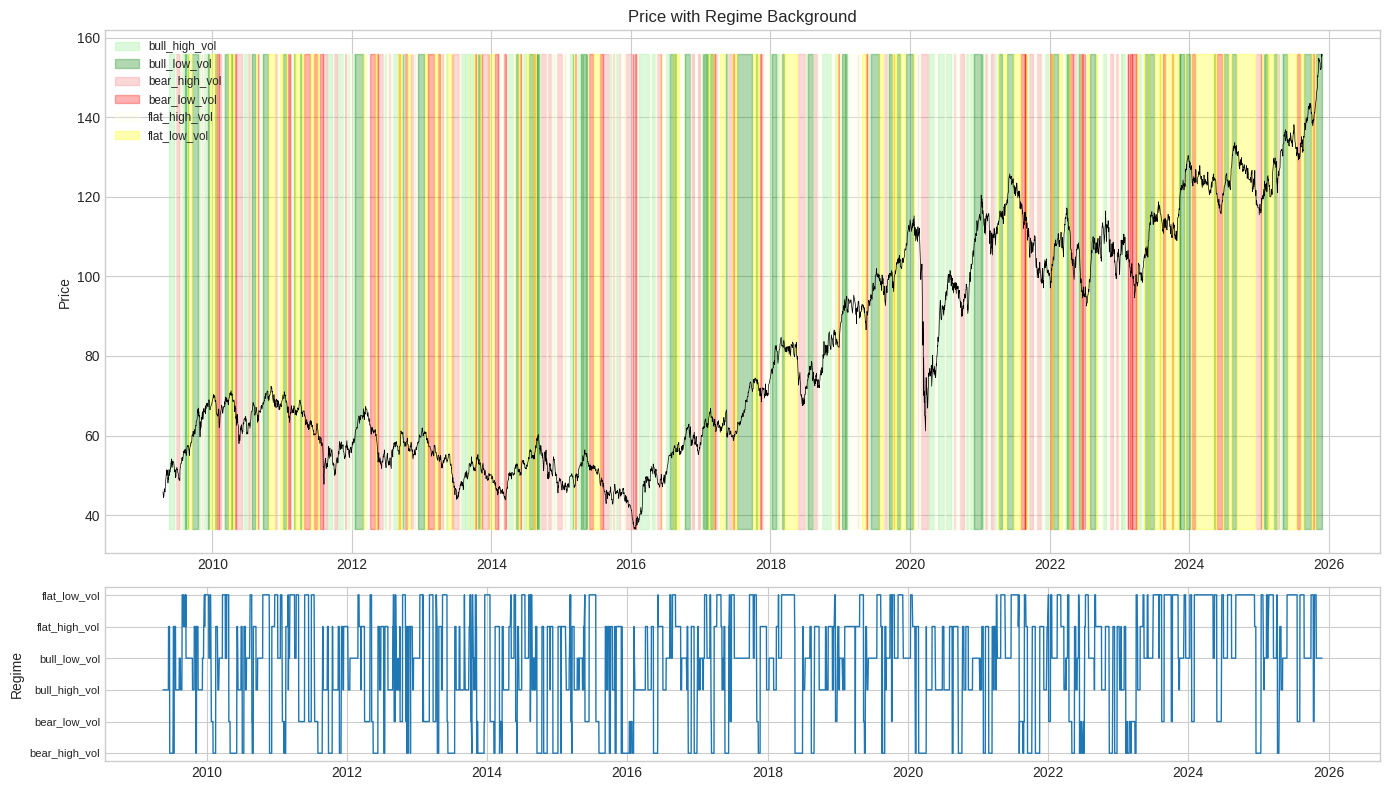

In [20]:
# Preço com background de regime
df_manual_indexed = df_manual.set_index('date')

price_plotter = PriceRegimePlotter(regime_column='regime')
fig = price_plotter.plot(df_manual_indexed)
plt.show()

## Etapa 11: Walk-Forward Validation

Para evitar overfitting, usamos walk-forward validation.

Isso simula como o modelo performaria em tempo real, sempre treinando no passado e testando no futuro.

In [21]:
from src.analysis.time_series_splitter import TimeSeriesSplitter

# Criar splitter
splitter = TimeSeriesSplitter(train_ratio=0.7)

# Demonstrar walk-forward splits
print("=== Walk-Forward Splits ===")
for split in splitter.walk_forward_split(df, n_folds=5, min_train_size=252):
    train_start = split.train['date'].min().date()
    train_end = split.train['date'].max().date()
    test_start = split.test['date'].min().date()
    test_end = split.test['date'].max().date()
    
    print(f"\nFold {split.fold}:")
    print(f"  Train: {train_start} a {train_end} ({len(split.train)} obs)")
    print(f"  Test:  {test_start} a {test_end} ({len(split.test)} obs)")

=== Walk-Forward Splits ===

Fold 0:
  Train: 2009-04-17 a 2010-04-28 (252 obs)
  Test:  2010-04-29 a 2013-06-07 (769 obs)

Fold 1:
  Train: 2009-04-17 a 2013-06-07 (1021 obs)
  Test:  2013-06-10 a 2016-07-18 (769 obs)

Fold 2:
  Train: 2009-04-17 a 2016-07-18 (1790 obs)
  Test:  2016-07-19 a 2019-09-20 (769 obs)

Fold 3:
  Train: 2009-04-17 a 2019-09-20 (2559 obs)
  Test:  2019-09-23 a 2022-10-27 (769 obs)

Fold 4:
  Train: 2009-04-17 a 2022-10-27 (3328 obs)
  Test:  2022-10-28 a 2025-11-25 (769 obs)


## Etapa 12: Otimização com Algoritmo Genético (Otimizado)

O GA busca os melhores parâmetros automaticamente.

**Otimizações implementadas:**
1. **Paralelização**: Avaliação de fitness usa múltiplos cores CPU
2. **Cache**: Cromossomos idênticos não são reavaliados
3. **Numba**: Cálculo de slope ~10-50x mais rápido (após warm-up)
4. **KMeans otimizado**: Algoritmo Lloyd para melhor performance

**NOTA sobre Numba**: A primeira execução será mais lenta devido à compilação JIT. Execuções subsequentes serão significativamente mais rápidas. O cache do Numba persiste entre sessões.

**NOTA**: Esta etapa é computacionalmente intensiva. Reduzimos os parâmetros para demonstração.

In [22]:
from config.search_space import GAConfig, GASearchSpace
from src.optimization.genetic_algorithm import GeneticAlgorithm
from src.calculators.slope_calculator import SlopeCalculator
import multiprocessing as mp

# Verificar otimizações disponíveis
print("=== Verificação de Otimizações ===")
print(f"Numba disponível para SlopeCalculator: {SlopeCalculator.is_numba_available()}")
print(f"CPUs disponíveis para paralelização: {mp.cpu_count()}")

# Configuração do GA
# target_return e horizon são FIXOS - o GA otimiza apenas os parâmetros de feature engineering
ga_config = GAConfig(
    # Parâmetros de predição (fixos)
    target_return=0.01,   # Queremos prever variação de 1%
    horizon=2,            # Em 2 dias
    
    # Parâmetros do GA
    population_size=100,
    generations=1000,
    n_folds=3,
    stability_penalty=0.1,
    elite_size=2,
    
    # Early stopping
    early_stopping=True,  # Habilitado para parar quando convergir
)

print("\n=== Configuração do GA ===")
print(f"Target Return: {ga_config.target_return:.1%}")
print(f"Horizonte: {ga_config.horizon} dias")
print(f"População: {ga_config.population_size}")
print(f"Gerações: {ga_config.generations}")
print(f"Folds: {ga_config.n_folds}")
print(f"Early Stopping: {ga_config.early_stopping}")

# Estimativa de tempo
tempo_por_gen = ga_config.population_size * 0.035  # ~0.035s por cromossomo
tempo_total = ga_config.generations * tempo_por_gen
print(f"\nTempo estimado: {tempo_total/60:.1f} minutos")
print("\nNOTA: Use Ctrl+C para interromper e salvar checkpoint a qualquer momento.")

=== Verificação de Otimizações ===
Numba disponível para SlopeCalculator: True
CPUs disponíveis para paralelização: 12

=== Configuração do GA ===
Target Return: 1.0%
Horizonte: 2 dias
População: 100
Gerações: 1000
Folds: 3
Early Stopping: True

Tempo estimado: 58.3 minutos

NOTA: Use Ctrl+C para interromper e salvar checkpoint a qualquer momento.


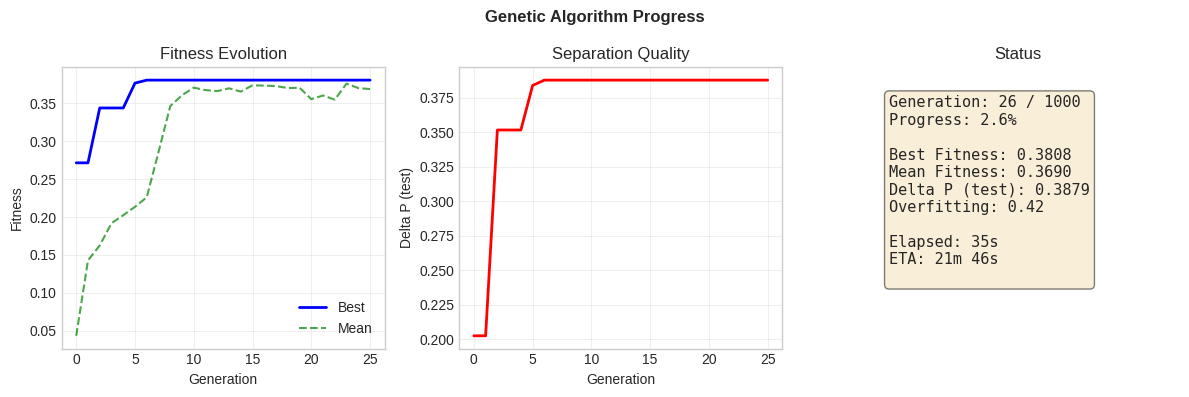

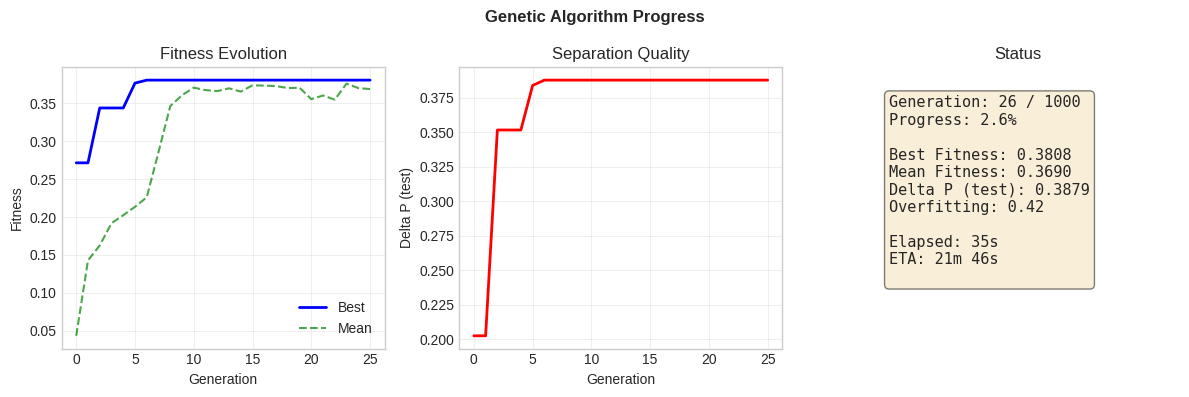


=== Melhores Parâmetros Encontrados ===
  Window Slope: 39
  Window Volatility: 14
  Window Rolling Return: 60
  N Clusters: 5
  Use Volatility: True
  Use Rolling Return: True

Parâmetros fixos (da configuração):
  Target Return: 1.00%
  Horizon: 2 dias

Métricas:
  Fitness: 0.3808
  Delta P (test): 0.3879
  Overfitting Ratio: 0.42

Estatísticas:
  Total avaliações: 2600


In [23]:
from src.optimization.genetic_algorithm import GeneticAlgorithm, GACheckpoint
from src.optimization.progress_callback import LiveProgressCallback

# Criar callback de progresso visual
progress_callback = LiveProgressCallback(
    total_generations=ga_config.generations,
    population_size=ga_config.population_size,
    update_every=1
)

# Executar GA
# NOTA: parallel=False é mais estável em Jupyter notebooks
ga = GeneticAlgorithm(
    df, 
    ga_config, 
    logger=logger,
    progress_callback=progress_callback,
    n_workers=None
)

try:
    result = ga.run(
        verbose=False,
        parallel=False,  # Desativado para evitar problemas no Jupyter
        auto_checkpoint_path="ga_checkpoint.json",
        checkpoint_every=10
    )
except KeyboardInterrupt:
    print("\nInterrompido! Salvando checkpoint...")
    ga.save_checkpoint("ga_checkpoint.json")
    print("Checkpoint salvo em 'ga_checkpoint.json'")
    print("Para retomar: checkpoint = GACheckpoint.load('ga_checkpoint.json')")
    raise

progress_callback.finalize()

print("\n=== Melhores Parâmetros Encontrados ===")
best = result.best_chromosome
print(f"  Window Slope: {best.window_slope}")
print(f"  Window Volatility: {best.window_volatility}")
print(f"  Window Rolling Return: {best.window_rolling_return}")
print(f"  N Clusters: {best.n_clusters}")
print(f"  Use Volatility: {best.use_volatility}")
print(f"  Use Rolling Return: {best.use_rolling_return}")

print(f"\nParâmetros fixos (da configuração):")
print(f"  Target Return: {ga_config.target_return:.2%}")
print(f"  Horizon: {ga_config.horizon} dias")

print(f"\nMétricas:")
print(f"  Fitness: {result.best_fitness:.4f}")
print(f"  Delta P (test): {result.best_metrics.delta_p_test:.4f}")
print(f"  Overfitting Ratio: {result.best_metrics.overfitting_ratio:.2f}")

print(f"\nEstatísticas:")
print(f"  Total avaliações: {result.all_evaluations}")

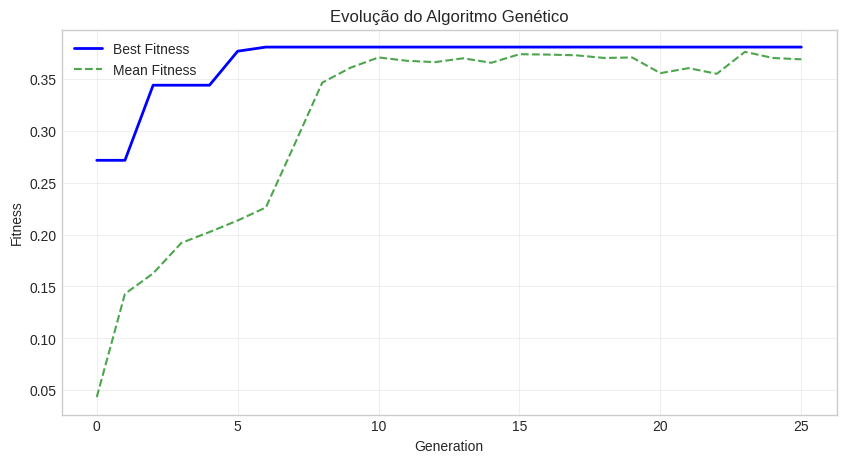

In [24]:
# Plotar evolução do fitness
generations = [h[0] for h in result.history]
best_fitness = [h[1] for h in result.history]
mean_fitness = [h[2] for h in result.history]

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(generations, best_fitness, 'b-', label='Best Fitness', linewidth=2)
ax.plot(generations, mean_fitness, 'g--', label='Mean Fitness', alpha=0.7)
ax.set_xlabel('Generation')
ax.set_ylabel('Fitness')
ax.set_title('Evolução do Algoritmo Genético')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

## Etapa 13: Aplicar Melhores Parâmetros

Agora aplicamos os parâmetros otimizados e recalculamos as probabilidades.

In [25]:
from src.optimization.calculator_factory import CalculatorFactory

# Factory para criar pipeline com os melhores parâmetros
# horizon vem da configuração, não do cromossomo
factory = CalculatorFactory(horizon=ga_config.horizon)
best_pipeline = factory.create_pipeline(best)
feature_cols = factory.get_feature_columns(best)
future_col_best = factory.get_future_return_column()

# Processar dados
df_best = best_pipeline.run(df)

# Clustering
best_kmeans = KMeansRegimeClassifier(
    n_clusters=best.n_clusters,
    feature_columns=feature_cols
)
df_best = best_kmeans.fit_predict(df_best)

# Probabilidades (target_return vem da configuração)
best_prob = ProbabilityCalculator(
    future_return_column=future_col_best,
    target_return=ga_config.target_return,
    regime_column='cluster'
)

best_report = best_prob.generate_report(df_best)

print("=== Relatório com Parâmetros Otimizados ===")
print(f"\nRetorno alvo: {ga_config.target_return:.1%}")
print(f"Horizonte: {ga_config.horizon} dias")
print(f"\nProbabilidade incondicional: {best_report['raw_probability_pct']:.2f}%")

# Interpretar clusters
slope_col_best = f'slope_{best.window_slope}'
best_interp = best_kmeans.interpret_clusters(df_best, slope_col_best)

print(f"\nProbabilidades por cluster:")
for cluster_id, data in sorted(best_report['conditional_probabilities'].items()):
    interp = best_interp.get(int(float(cluster_id)), 'unknown')
    print(f"  Cluster {cluster_id} ({interp.upper()}): P(hit) = {data['probability_pct']:.2f}% (n={data['count']})")

print(f"\nDelta P: {best_report['separation_metrics']['delta_p']:.4f}")
print(f"Information Ratio: {best_report['separation_metrics']['information_ratio']:.4f}")

=== Relatório com Parâmetros Otimizados ===

Retorno alvo: 1.0%
Horizonte: 2 dias

Probabilidade incondicional: 30.72%

Probabilidades por cluster:
  Cluster 0.0 (BULL): P(hit) = 28.74% (n=1291)
  Cluster 1.0 (BEAR): P(hit) = 37.75% (n=559)
  Cluster 2.0 (BEAR): P(hit) = 29.36% (n=1495)
  Cluster 3.0 (BEAR): P(hit) = 34.78% (n=23)
  Cluster 4.0 (BULL): P(hit) = 30.60% (n=670)

Delta P: 0.0901
Information Ratio: 0.0542


## Etapa 14: Visualizações com Parâmetros Otimizados

Agora repetimos todas as visualizações usando os parâmetros do indivíduo vencedor do GA.

In [26]:
# Estatísticas por cluster com parâmetros otimizados
stats_best = best_kmeans.compute_statistics(df_best, future_col_best)

print("=== Estatísticas por Cluster (Parâmetros Otimizados) ===")
for stat in stats_best:
    interp = best_interp.get(stat.cluster_id, 'unknown')
    print(f"\nCluster {stat.cluster_id} ({interp.upper()}):")
    print(f"  Observações: {stat.count} ({stat.percentage:.1f}%)")
    print(f"  Retorno futuro médio: {stat.future_return_mean:.4f}")
    print(f"  Desvio padrão: {stat.future_return_std:.4f}")
    print(f"  Features médias: {stat.feature_means}")

=== Estatísticas por Cluster (Parâmetros Otimizados) ===

Cluster 0 (BULL):
  Observações: 1293 (32.0%)
  Retorno futuro médio: 0.0010
  Desvio padrão: 0.0168
  Features médias: {'slope_39': np.float64(0.0016805889182350778), 'volatility_14': np.float64(0.009792493680666828), 'log_return_rolling_60': np.float64(0.06727372631328604)}

Cluster 1 (BEAR):
  Observações: 559 (13.8%)
  Retorno futuro médio: 0.0010
  Desvio padrão: 0.0284
  Features médias: {'slope_39': np.float64(-0.002620646178727205), 'volatility_14': np.float64(0.019544479830737448), 'log_return_rolling_60': np.float64(-0.13871036500289283)}

Cluster 2 (BEAR):
  Observações: 1495 (37.0%)
  Retorno futuro médio: -0.0001
  Desvio padrão: 0.0184
  Features médias: {'slope_39': np.float64(-0.0008525545147496062), 'volatility_14': np.float64(0.01246840285097558), 'log_return_rolling_60': np.float64(-0.024429586999571793)}

Cluster 3 (BEAR):
  Observações: 23 (0.6%)
  Retorno futuro médio: 0.0010
  Desvio padrão: 0.0620
  Featu

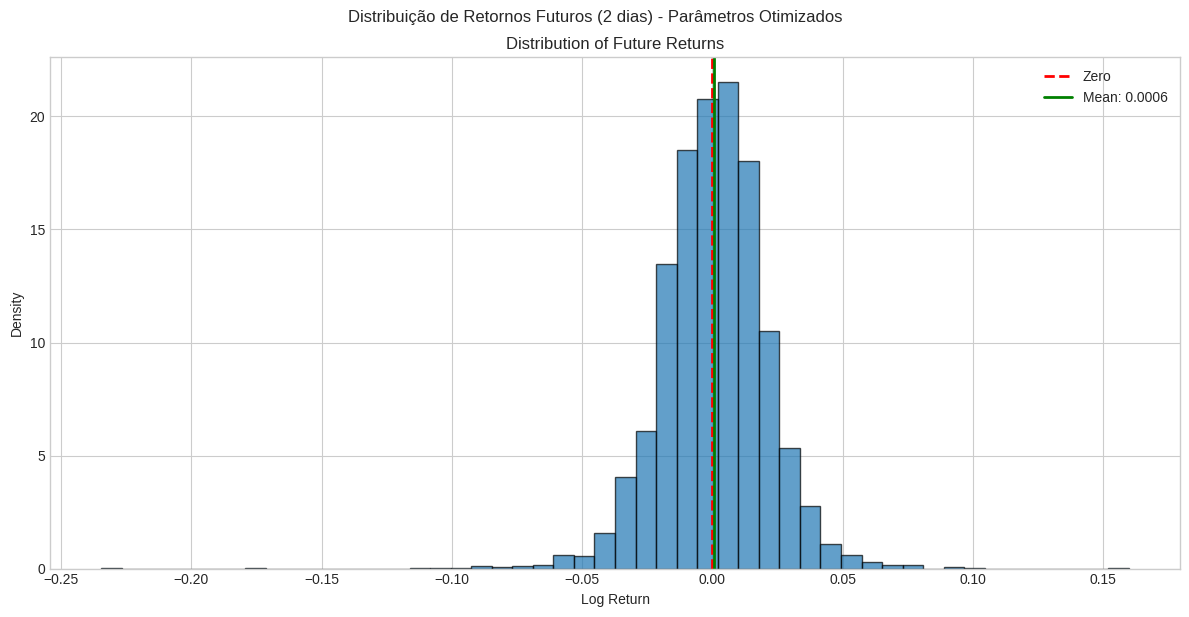

In [27]:
# Histograma de retornos com parâmetros otimizados
hist_plotter_best = HistogramPlotter(
    return_column=future_col_best,
    regime_column='cluster'
)

fig = hist_plotter_best.plot(df_best)
plt.suptitle(f'Distribuição de Retornos Futuros ({ga_config.horizon} dias) - Parâmetros Otimizados', y=1.02)
plt.show()

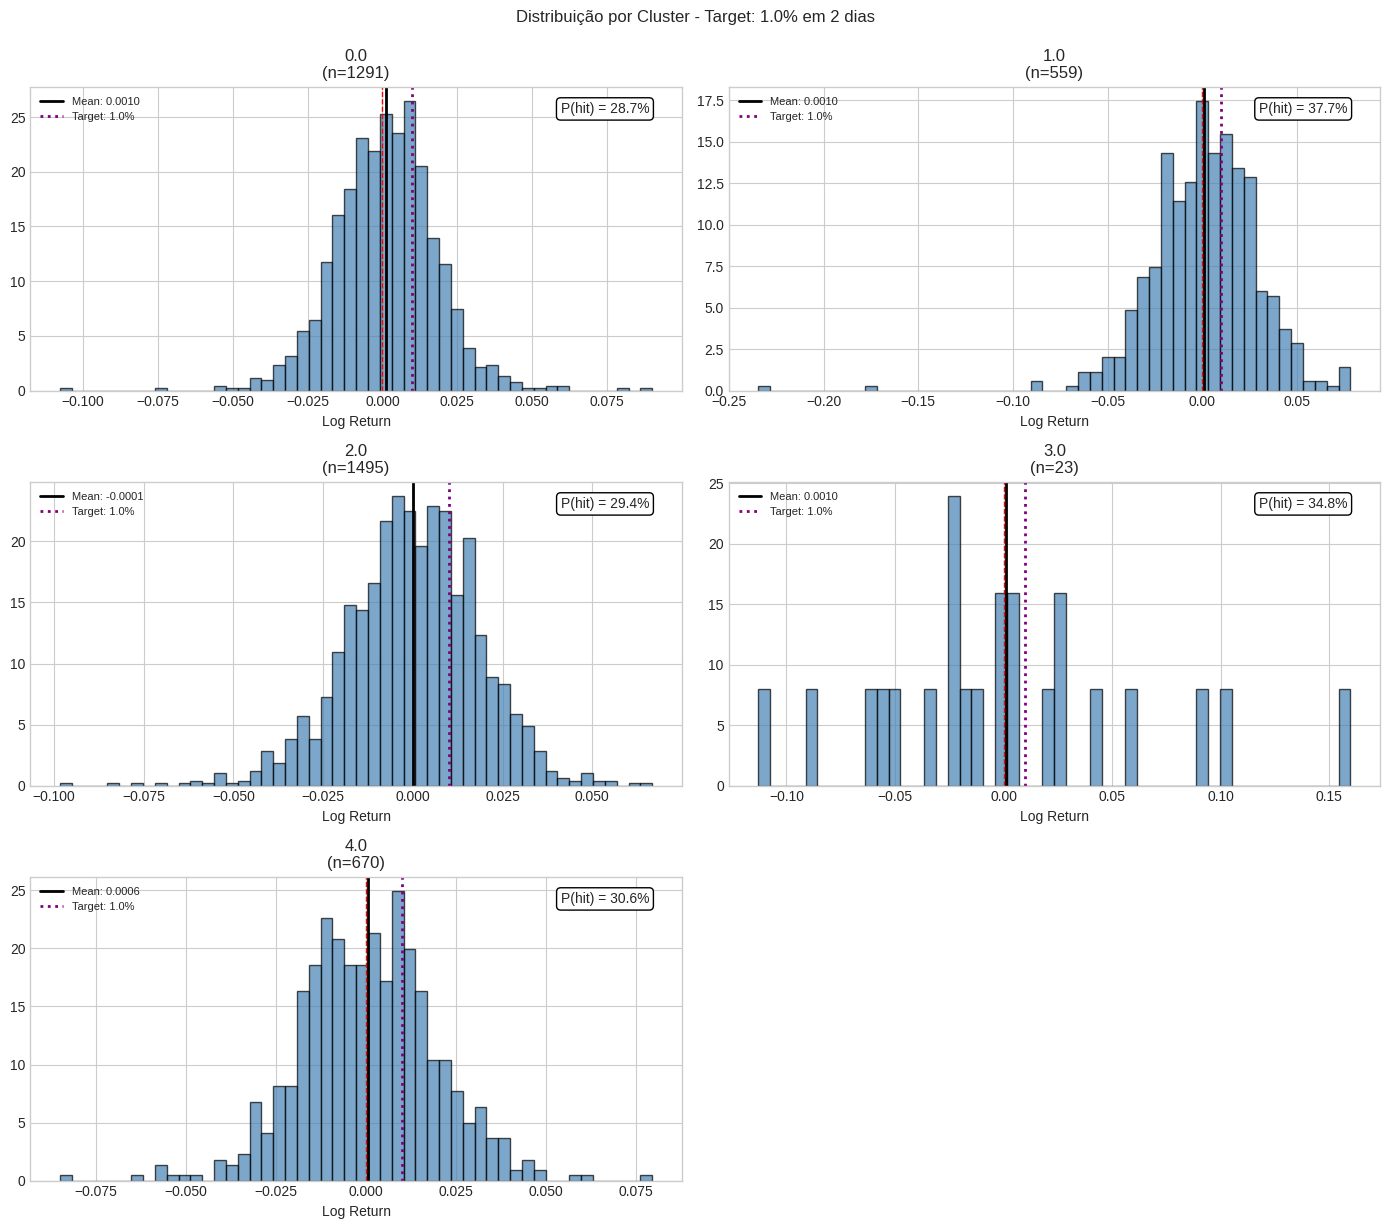

In [28]:
# Histogramas por cluster com linha do target
fig = hist_plotter_best.plot_by_regime(df_best, target_return=ga_config.target_return)
plt.suptitle(f'Distribuição por Cluster - Target: {ga_config.target_return:.1%} em {ga_config.horizon} dias', y=1.02)
plt.show()

/home/flavio/projetos/quantnote/src/visualization/histogram_plotter.py:165: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_price.legend(loc='upper left', fontsize='small')


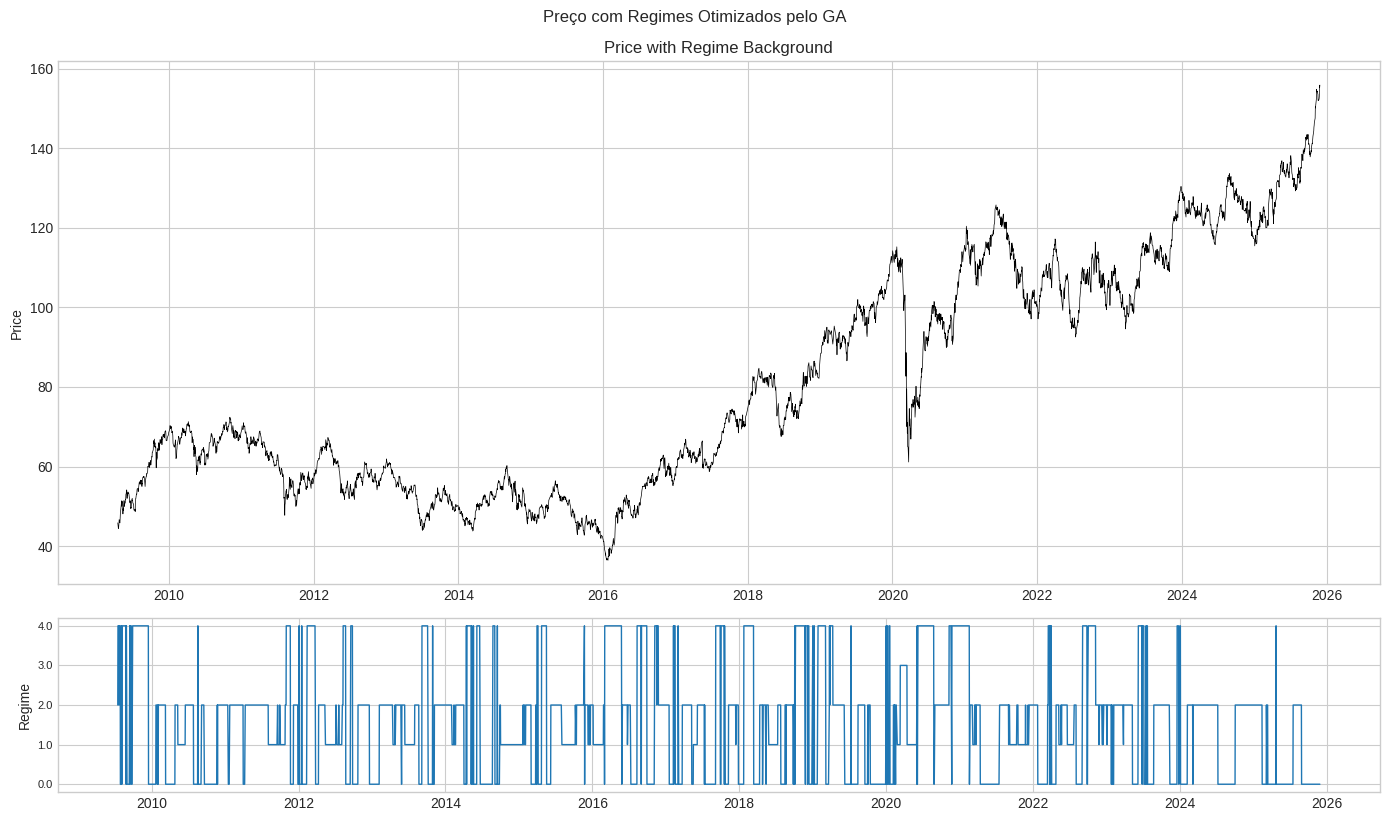

In [29]:
# Preço com background de cluster otimizado
df_best_indexed = df_best.set_index('date')

price_plotter_best = PriceRegimePlotter(regime_column='cluster')
fig = price_plotter_best.plot(df_best_indexed)
plt.suptitle('Preço com Regimes Otimizados pelo GA', y=1.02)
plt.show()

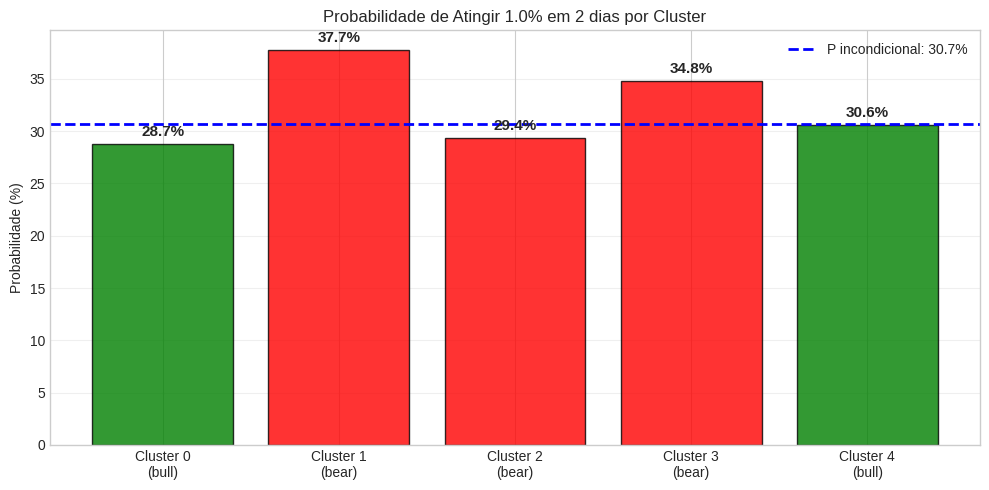


Delta P (separação): 0.0901
Melhor cluster: 1.0
Pior cluster: 0.0


In [30]:
# Gráfico de barras: Probabilidade por Cluster
clusters = []
probs = []
colors = []
color_map = {'bull': 'green', 'bear': 'red', 'flat': 'gold'}

for cluster_id, data in sorted(best_report['conditional_probabilities'].items()):
    interp = best_interp.get(int(float(cluster_id)), 'flat')
    clusters.append(f"Cluster {int(float(cluster_id))}\n({interp})")
    probs.append(data['probability_pct'])
    colors.append(color_map.get(interp, 'gray'))

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(clusters, probs, color=colors, edgecolor='black', alpha=0.8)

# Linha horizontal para probabilidade incondicional
ax.axhline(y=best_report['raw_probability_pct'], color='blue', linestyle='--', 
           linewidth=2, label=f"P incondicional: {best_report['raw_probability_pct']:.1f}%")

# Adicionar valores nas barras
for bar, prob in zip(bars, probs):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
            f'{prob:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_ylabel('Probabilidade (%)')
ax.set_title(f'Probabilidade de Atingir {ga_config.target_return:.1%} em {ga_config.horizon} dias por Cluster')
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nDelta P (separação): {best_report['separation_metrics']['delta_p']:.4f}")
print(f"Melhor cluster: {max(best_report['conditional_probabilities'].items(), key=lambda x: x[1]['probability_pct'])[0]}")
print(f"Pior cluster: {min(best_report['conditional_probabilities'].items(), key=lambda x: x[1]['probability_pct'])[0]}")

In [31]:
# Identificar regime atual e probabilidade
last_row = df_best.iloc[-1]
current_cluster = int(last_row['cluster'])
current_interp = best_interp.get(current_cluster, 'unknown')
current_prob = best_report['conditional_probabilities'][str(float(current_cluster))]['probability_pct']

print("=" * 60)
print("SITUAÇÃO ATUAL")
print("=" * 60)
print(f"\nData mais recente: {last_row['date'].strftime('%Y-%m-%d')}")
print(f"Preço de fechamento: R$ {last_row['close']:.2f}")
print(f"\nRegime atual: Cluster {current_cluster} ({current_interp.upper()})")
print(f"\nProbabilidade de atingir {ga_config.target_return:.1%} em {ga_config.horizon} dias:")
print(f"  -> {current_prob:.1f}%")
print(f"\nProbabilidade incondicional (média histórica): {best_report['raw_probability_pct']:.1f}%")

# Comparação
diff = current_prob - best_report['raw_probability_pct']
if diff > 0:
    print(f"\n✅ Regime atual tem probabilidade {diff:.1f} pontos percentuais ACIMA da média")
else:
    print(f"\n⚠️ Regime atual tem probabilidade {abs(diff):.1f} pontos percentuais ABAIXO da média")

SITUAÇÃO ATUAL

Data mais recente: 2025-11-28
Preço de fechamento: R$ 155.85

Regime atual: Cluster 0 (BULL)

Probabilidade de atingir 1.0% em 2 dias:
  -> 28.7%

Probabilidade incondicional (média histórica): 30.7%

⚠️ Regime atual tem probabilidade 2.0 pontos percentuais ABAIXO da média


<cell_type>markdown</cell_type>## Etapa 15: Análise Dual - Fechar vs Tocar

Comparamos duas probabilidades diferentes:
- **P(fechar)**: Probabilidade do preço FECHAR acima do alvo em t+H
- **P(tocar)**: Probabilidade do preço TOCAR o alvo em algum momento entre t+1 e t+H

Esta análise é útil para operações de opções e stop-loss/take-profit.

In [32]:
from src.calculators import FutureTouchCalculatorVectorized
from src.analysis import DualProbabilityCalculator

# Adicionar colunas de touch ao DataFrame com parâmetros otimizados
touch_calc = FutureTouchCalculatorVectorized(horizon=ga_config.horizon)
df_dual = touch_calc.calculate(df_best)

print("=== Novas Colunas de Touch ===")
print(f"Colunas adicionadas: {touch_calc.output_columns}")
print(f"\nExemplo dos dados:")
print(df_dual[['date', 'close', f'log_return_future_{ga_config.horizon}', 
               f'log_return_touch_max_{ga_config.horizon}']].head(10))

=== Novas Colunas de Touch ===
Colunas adicionadas: {'log_return_touch_max_2', 'log_return_touch_min_2'}

Exemplo dos dados:
        date      close  log_return_future_2  log_return_touch_max_2
0 2009-04-17  45.849998            -0.018935               -0.013393
1 2009-04-20  44.419998             0.032775                0.032775
2 2009-04-22  44.990002             0.037090                0.040511
3 2009-04-23  45.900002             0.000000                0.020486
4 2009-04-24  46.689999            -0.018155               -0.006230
5 2009-04-27  45.900002             0.019418                0.028988
6 2009-04-28  45.849998             0.047907                0.047907
7 2009-04-29  46.799999             0.066140                0.066140
8 2009-04-30  48.099998             0.051657                0.052052
9 2009-05-04  50.000000             0.026837                0.054488


In [33]:
# Criar calculador dual
dual_calc = DualProbabilityCalculator(
    close_return_column=f'log_return_future_{ga_config.horizon}',
    touch_return_column=f'log_return_touch_max_{ga_config.horizon}',  # Para alvos de alta
    target_return=ga_config.target_return,
    regime_column='cluster'
)

# Imprimir comparação formatada
dual_calc.print_comparison(df_dual)


Probabilidade de atingir 1.0% de retorno

📊 Probabilidades Gerais (sem condicionamento):
   P(fechar ≥ alvo)  = 30.7%
   P(tocar o alvo)   = 55.6%
   Ratio touch/close = 1.81x

📈 Probabilidades por Regime:
   Regime     P(fechar)    P(tocar)     Ratio      N       
   ----------------------------------------------------
   2.0        29.4%        54.6%        1.86x      1495    
   4.0        30.6%        57.6%        1.88x      670     
   0.0        28.7%        49.4%        1.72x      1291    
   1.0        37.7%        68.0%        1.80x      559     
   3.0        34.8%        82.6%        2.38x      23      

📐 Métricas de Separação:
   Delta P (close): 0.090
   Delta P (touch): 0.332


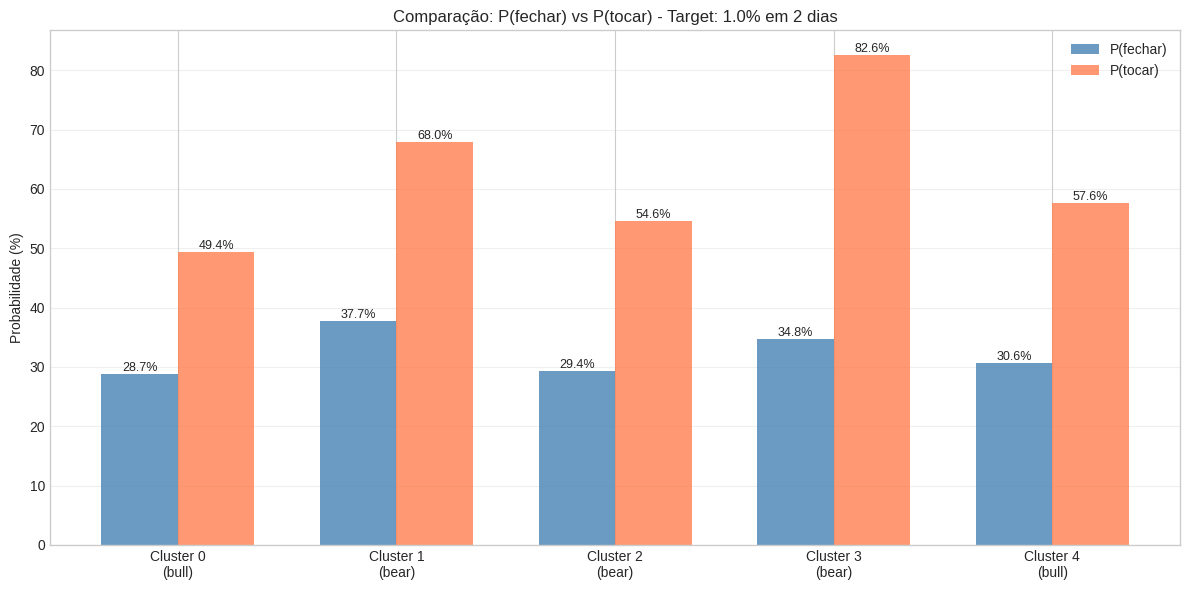


=== Ratio Touch/Close por Cluster ===
Cluster 0 (bull): 1.72x mais provável tocar que fechar
Cluster 1 (bear): 1.80x mais provável tocar que fechar
Cluster 2 (bear): 1.86x mais provável tocar que fechar
Cluster 3 (bear): 2.38x mais provável tocar que fechar
Cluster 4 (bull): 1.88x mais provável tocar que fechar


In [34]:
# Gráfico comparativo: P(fechar) vs P(tocar) por cluster
dual_report = dual_calc.generate_report(df_dual)

fig, ax = plt.subplots(figsize=(12, 6))

clusters_list = sorted(dual_report['conditional_probabilities'].keys())
x = np.arange(len(clusters_list))
width = 0.35

close_probs = [dual_report['conditional_probabilities'][c]['prob_close'] * 100 for c in clusters_list]
touch_probs = [dual_report['conditional_probabilities'][c]['prob_touch'] * 100 for c in clusters_list]

bars1 = ax.bar(x - width/2, close_probs, width, label='P(fechar)', color='steelblue', alpha=0.8)
bars2 = ax.bar(x + width/2, touch_probs, width, label='P(tocar)', color='coral', alpha=0.8)

# Labels nos clusters
cluster_labels = []
for c in clusters_list:
    interp = best_interp.get(int(float(c)), 'unknown')
    cluster_labels.append(f"Cluster {int(float(c))}\n({interp})")

ax.set_xticks(x)
ax.set_xticklabels(cluster_labels)
ax.set_ylabel('Probabilidade (%)')
ax.set_title(f'Comparação: P(fechar) vs P(tocar) - Target: {ga_config.target_return:.1%} em {ga_config.horizon} dias')
ax.legend()

# Adicionar valores nas barras
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height, f'{height:.1f}%',
            ha='center', va='bottom', fontsize=9)

for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height, f'{height:.1f}%',
            ha='center', va='bottom', fontsize=9)

ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Ratio touch/close
print("\n=== Ratio Touch/Close por Cluster ===")
for c in clusters_list:
    data = dual_report['conditional_probabilities'][c]
    ratio = data['touch_vs_close_ratio']
    interp = best_interp.get(int(float(c)), 'unknown')
    print(f"Cluster {int(float(c))} ({interp}): {ratio:.2f}x mais provável tocar que fechar")

In [35]:
# Situação atual com análise dual
last_row = df_dual.iloc[-1]
current_cluster = int(last_row['cluster'])
current_interp = best_interp.get(current_cluster, 'unknown')

current_data = dual_report['conditional_probabilities'][str(float(current_cluster))]
current_prob_close = current_data['prob_close'] * 100
current_prob_touch = current_data['prob_touch'] * 100

print("=" * 60)
print("SITUAÇÃO ATUAL - ANÁLISE DUAL")
print("=" * 60)
print(f"\nData: {last_row['date'].strftime('%Y-%m-%d')}")
print(f"Preço: R$ {last_row['close']:.2f}")
print(f"Regime: Cluster {current_cluster} ({current_interp.upper()})")

print(f"\nProbabilidade de atingir {ga_config.target_return:.1%} em {ga_config.horizon} dias:")
print(f"  P(fechar ≥ alvo): {current_prob_close:.1f}%")
print(f"  P(tocar o alvo):  {current_prob_touch:.1f}%")
print(f"  Ratio:            {current_prob_touch/current_prob_close:.2f}x")

print(f"\n📈 Interpretação:")
print(f"  É {current_prob_touch/current_prob_close:.1f}x mais provável o preço TOCAR o alvo")
print(f"  do que FECHAR acima dele.")
print(f"\n  Isso é útil para:")
print(f"  - Opções: P(tocar) relevante para barreiras knock-in/knock-out")
print(f"  - Trading: P(tocar) para stop-loss e take-profit")

SITUAÇÃO ATUAL - ANÁLISE DUAL

Data: 2025-11-28
Preço: R$ 155.85
Regime: Cluster 0 (BULL)

Probabilidade de atingir 1.0% em 2 dias:
  P(fechar ≥ alvo): 28.7%
  P(tocar o alvo):  49.4%
  Ratio:            1.72x

📈 Interpretação:
  É 1.7x mais provável o preço TOCAR o alvo
  do que FECHAR acima dele.

  Isso é útil para:
  - Opções: P(tocar) relevante para barreiras knock-in/knock-out
  - Trading: P(tocar) para stop-loss e take-profit


## Etapa 16: Salvando o Modelo para Produção

Usamos `RegimePredictor` para encapsular o modelo treinado e facilitar previsões futuras.

In [36]:
from src.prediction import RegimePredictor

# Criar predictor a partir dos resultados do GA
predictor = RegimePredictor(
    chromosome=best,                      # Cromossomo otimizado
    target_return=ga_config.target_return,
    horizon=ga_config.horizon,
    ticker=ticker,
    data_dir="../data"
)

# Treinar com os dados históricos
predictor.fit(df)

# Salvar modelo para uso futuro
predictor.save("../models/bova11_predictor")
print("✅ Modelo salvo em ../models/bova11_predictor.joblib e .json")

# Carregar modelo (simulando uso em produção)
predictor_loaded = RegimePredictor.load("../models/bova11_predictor", data_dir="../data")
print("✅ Modelo carregado com sucesso!")

# Fazer previsão do regime atual
result = predictor_loaded.predict_current()

# Exibir status formatado
predictor_loaded.print_status(result)

AttributeError: 'KMeansRegimeClassifier' object has no attribute '_model'

## Etapa 17: Otimização Multi-Alvo

Para diferentes targets de retorno, o GA pode encontrar parâmetros diferentes.
O `MultiTargetOptimizer` roda GAs independentes para cada alvo e cria uma matriz de probabilidades.

**NOTA**: Esta etapa é MUITO intensiva computacionalmente. Use com cautela.

In [38]:
# Exemplo de uso do MultiTargetOptimizer (NÃO EXECUTAR - apenas demonstração)
# Este código levaria MUITO tempo para rodar

from config.search_space import TargetGrid
from src.optimization import MultiTargetOptimizer
from src.prediction import MultiTargetPredictor

# Configurar grid de targets (1% a 5%, step 1%)
target_grid = TargetGrid(
    target_min=0.01,   # 1%
    target_max=0.05,   # 5%
    target_step=0.01   # 1%
)

print("=== Configuração Multi-Target ===")
print(f"Targets: {target_grid.to_array()}")
print(f"Total de GAs a executar: {len(target_grid)}")

# Configuração do GA (reduzida para demo)
multi_ga_config = GAConfig(
    horizon=ga_config.horizon,
    population_size=50,      # Reduzido para demo
    generations=100,         # Reduzido para demo
    n_folds=3,
    early_stopping=True
)

# DESCOMENTE PARA EXECUTAR (demora!)
# optimizer = MultiTargetOptimizer(
#     df=df,
#     horizon=ga_config.horizon,
#     target_grid=target_grid,
#     ga_config=multi_ga_config
# )
# 
# results = optimizer.run(verbose=True)
# results.save("../models/multi_target_h2")
# 
# # Criar predictor
# multi_predictor = MultiTargetPredictor.from_optimization(results, df)
# multi_predictor.save("../models/multi_target_h2_predictor")
# 
# # Ver matriz de probabilidades
# matrix = multi_predictor.predict_current(ticker)
# multi_predictor.print_matrix(ticker)

print("\n⚠️ Código comentado para evitar execução longa.")
print("Descomente as linhas acima para executar a otimização multi-alvo.")

=== Configuração Multi-Target ===
Targets: [np.float64(0.01), np.float64(0.02), np.float64(0.03), np.float64(0.04), np.float64(0.05)]
Total de GAs a executar: 5

⚠️ Código comentado para evitar execução longa.
Descomente as linhas acima para executar a otimização multi-alvo.


## Etapa 18: Grade de Strikes para Opções

O `StrikeGridOptimizer` é similar ao MultiTargetOptimizer, mas trabalha com preços absolutos (strikes).
Ideal para precificação de opções.

**Fluxo:**
1. Define strikes (ex: R$ 120, 125, 130...)
2. Converte cada strike para target return: `(strike / preço_atual) - 1`
3. Roda GA para cada target exato
4. Gera matriz de probabilidades por strike

In [ ]:
# Exemplo de uso do StrikeGridOptimizer com Progress Callback

from src.optimization import StrikeGridOptimizer
from src.optimization.progress_callback import SimpleProgressCallback
from src.prediction import StrikeGridPredictor
from config.search_space import GAConfig

# Preço atual do ativo
current_price = df['close'].iloc[-1]
print(f"Preço atual: R$ {current_price:.2f}")

# Definir strikes (exemplo para BOVA11)
strikes = list(range(int(current_price * 0.95), int(current_price * 1.10), 2))  # -5% a +10%
print(f"\nStrikes definidos: {strikes}")
print(f"Total de GAs a executar: {len(strikes)}")

# Preview da conversão strike → target
print("\n=== Preview Strike → Target ===")
print(f"{'Strike':<12} {'Retorno':<12} {'Direção':<10}")
print("-" * 34)
for strike in strikes[:5]:
    target_return = (strike / current_price) - 1
    direction = 'UP' if target_return > 0 else 'DOWN' if target_return < 0 else 'ATM'
    print(f"R$ {strike:<9.2f} {target_return*100:+.2f}%       {direction:<10}")
if len(strikes) > 5:
    print(f"... ({len(strikes) - 5} mais)")

# Configuração do GA para strike grid (reduzida para demo)
strike_ga_config = GAConfig(
    horizon=ga_config.horizon,  # Reutiliza horizonte da config principal
    population_size=50,         # Reduzido para demo
    generations=100,            # Reduzido para demo
    n_folds=3,
    early_stopping=True
)

# Factory para criar callback de progresso para cada GA
def create_ga_callback(strike_idx, strike):
    return SimpleProgressCallback(
        total_generations=strike_ga_config.generations,
        print_every=5  # Atualiza a cada 5 gerações
    )

# Executar otimização
strike_optimizer = StrikeGridOptimizer(
    df=df,
    current_price=current_price,
    strikes=strikes,
    horizon=strike_ga_config.horizon,
    ga_config=strike_ga_config
)

print(f"\n⏳ Iniciando otimização para {len(strikes)} strikes...")
print(f"   Configuração: {strike_ga_config.generations} gerações, população {strike_ga_config.population_size}")
print(f"   Early stopping: {strike_ga_config.early_stopping}")

strike_results = strike_optimizer.run(
    verbose=True,
    ga_progress_callback_factory=create_ga_callback,  # Mostra progresso de cada GA!
    parallel_ga=False  # Melhor para Jupyter notebooks
)

# Salvar resultados
strike_results.save("../models/strike_grid_h2")

# Criar predictor
strike_predictor = StrikeGridPredictor.from_optimization(strike_results, df)
strike_predictor.save("../models/strike_grid_h2_predictor")

# Ver matriz de strikes
strike_predictor.print_matrix(ticker)

## Conclusão

Este notebook demonstrou o fluxo completo do sistema QuantNote:

1. **Configuração** com validação via Pydantic
2. **Obtenção de dados** do Yahoo Finance com rate limiting
3. **Validação** de dados com múltiplos validators
4. **Pipeline de calculadores** com resolução automática de dependências
5. **Classificação de regimes** (manual e K-Means)
6. **Cálculo de probabilidades** condicionais
7. **Visualização** de distribuições
8. **Walk-forward validation** para evitar overfitting
9. **Otimização** com algoritmo genético
10. **Análise dual** - P(fechar) vs P(tocar)

### Métricas de Probabilidade

- **P(fechar)**: Probabilidade de fechar acima do alvo no final do período
- **P(tocar)**: Probabilidade de atingir o alvo em algum momento durante o período

### Próximos Passos

- Testar com outros ativos
- Ajustar parâmetros do GA para busca mais ampla
- Implementar novos indicadores (RSI, MACD, etc.)
- Integrar com sistema de backtesting
- Usar P(tocar) para otimização de opções